# PAF Calculations

## Starting with SBP -> HF 

This is from a categorical risk based on the SBP level of a simulant. Therefore, we will use the PAF equation and GBD risk exposure values to find the PAFs. 

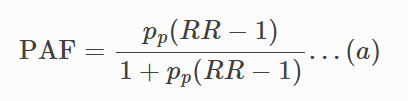

The Pp value is the percent exposed in the population. This can be found in the interactive model. However, this means that I only found it for Alabama. It will need to be done either nationally or for each state. 

In [1]:
import pandas as pd, numpy as np, os
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats as sp
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import random
import scipy.integrate as integrate
from risk_distributions import EnsembleDistribution
import math 
from typing import List, Tuple, Union

In [2]:
SBP_PAF = pd.DataFrame(np.array([['<120',1,1,1,0.44253490870032225],['120-129',1.13,1.27,1.43,0.24583780880773362],['130-139',1.3,1.5,1.73,0.1742749731471536],['140+',1.43,1.76,2.17,0.13735230934479054]]),
                   columns=['SBP_Group', 'RR_lower', 'RR', 'RR_upper','Pp'])
SBP_PAF

,SBP_Group,RR_lower,RR,RR_upper,Pp
0,<120,1,1,1,0.44253490870032225
1,120-129,1.13,1.27,1.43,0.24583780880773362
2,130-139,1.3,1.5,1.73,0.1742749731471536
3,140+,1.43,1.76,2.17,0.13735230934479054


In [3]:
SBP_PAF['Pp'] = pd.to_numeric(SBP_PAF['Pp'])
SBP_PAF['RR_lower'] = pd.to_numeric(SBP_PAF['RR_lower'])
SBP_PAF['RR'] = pd.to_numeric(SBP_PAF['RR'])
SBP_PAF['RR_upper'] = pd.to_numeric(SBP_PAF['RR_upper'])
SBP_PAF['RR_PP_lower'] = SBP_PAF.RR_lower * SBP_PAF.Pp
SBP_PAF['RR_PP'] = SBP_PAF.RR * SBP_PAF.Pp
SBP_PAF['RR_PP_upper'] = SBP_PAF.RR_upper * SBP_PAF.Pp
SBP_PAF

,SBP_Group,RR_lower,RR,RR_upper,Pp,RR_PP_lower,RR_PP,RR_PP_upper
0,<120,1.00,1.00,1.00,0.442535,0.442535,0.442535,0.442535
1,120-129,1.13,1.27,1.43,0.245838,0.277797,0.312214,0.351548
2,130-139,1.30,1.50,1.73,0.174275,0.226557,0.261412,0.301496
3,140+,1.43,1.76,2.17,0.137352,0.196414,0.241740,0.298055


In [4]:
RR_lower = SBP_PAF.RR_PP_lower.sum()
RR = SBP_PAF.RR_PP.sum()
RR_upper = SBP_PAF.RR_PP_upper.sum()

PAF_lower = (RR_lower - 1) / (RR_lower)
PAF = (RR - 1) / (RR)
PAF_upper = (RR_upper - 1) / (RR_upper)

print(PAF_lower, PAF, PAF_upper)

0.12534114983347655 0.20502516317370853 0.2824510731441321


## Now for BMI -> HF 

This is a continuous risk for the BMI of the simulant and its effect on HF. There is not as clear cut a formula for this type of risk. 

### Create the BMI pdf function

In [5]:
weights = pd.read_csv('/ihme/epi/risk/ensemble/_weights/gbd_2019/metab_bmi_adult.csv')
weights = weights.drop(columns=[c for c in weights.columns if '_id' in c]).loc[0]
weights

exp           0.001915
gamma         0.028420
invgamma      0.085432
llogis        0.187009
gumbel        0.220315
invweibull    0.140573
weibull       0.010840
lnorm         0.057513
norm          0.011908
glnorm        0.000000
betasr        0.135648
mgamma        0.007814
mgumbel       0.112612
Name: 0, dtype: float64

In [6]:
w_exponential = weights['exp']
w_gamma = weights['gamma']
w_inverse_gamma = weights['invgamma']
w_log_logistic = weights['llogis']
w_gumbel = weights['gumbel']
w_invweibull = weights['invweibull']
w_weibull = weights['weibull']
w_log_normal = weights['lnorm']
w_normal = weights['norm']
w_beta = weights['betasr']
w_mirror_gamma = weights['mgamma']
w_mirror_gumbel = weights['mgumbel']

In [54]:
params = get_draws(release_id=6,
         year_id=2019,
         sex_id=[1,2],
         location_id=523,
         age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32],
         gbd_id_type='modelable_entity_id',
         gbd_id=[2548,18706],
         source='epi')

In [84]:
data = params.set_index(['sex_id','modelable_entity_id','age_group_id'])
data = (data[[c for c in data.columns if 'draw' in c]].stack().reset_index()
        .rename(columns={'level_3':'draw',0:'value'}))
data['parameter'] = np.where(data.modelable_entity_id==2548, 'mean', 'standard_deviation')
data = data.drop(columns='modelable_entity_id')
data = (data.pivot_table(index=['sex_id','age_group_id','draw'], columns='parameter', values='value')
        .reset_index())
data.head()

parameter,sex_id,age_group_id,draw,mean,standard_deviation
0,1,10,draw_0,28.898947,9.591207
1,1,10,draw_1,29.912804,9.922810
2,1,10,draw_10,28.482101,5.695761
3,1,10,draw_100,27.270368,9.091147
4,1,10,draw_101,26.607156,3.859586


In [91]:
new_data = pd.DataFrame()
for i in range(3):
    for j in range(data.age_group_id.nunique()):
        age_group_id = data.age_group_id.unique()[j]
        data_current = data.loc[(data.sex_id == i) & (data.age_group_id == age_group_id)]
        data_current_reasonable = data_current.standard_deviation.loc[data_current.standard_deviation < 15]
        for k in range(len(data_current)):
            if data_current.standard_deviation.iloc[k] > 15: 
                y = random.sample(data_current_reasonable.tolist(),50)
                avg = np.mean(y)
                data_current.standard_deviation.iloc[k] = avg 
        new_data = pd.concat([new_data,data_current])

Text(0.5, 1.0, 'Standard Deviation by Age Group')

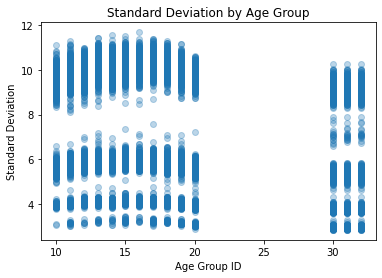

In [94]:
plt.scatter(new_data.age_group_id, new_data.standard_deviation, alpha=0.3)
plt.xlabel("Age Group ID")
plt.ylabel("Standard Deviation")
plt.title("Standard Deviation by Age Group") 

Text(0, 0.5, 'Counts')

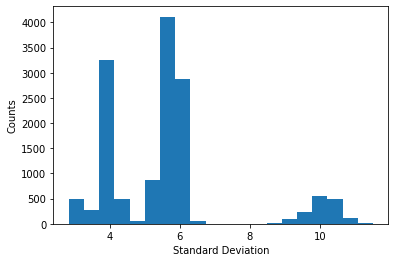

In [59]:
plt.hist(new_data.standard_deviation, bins=20)
plt.xlabel("Standard Deviation")
plt.ylabel("Counts")

In [60]:
def bmi_ensemble(x, mean, std):
    result = (EnsembleDistribution({'betasr': [w_beta], 'exp': [w_exponential], 'gamma': [w_gamma], 'gumbel': [w_gumbel], 
                                 'invgamma': [w_inverse_gamma], 'invweibull': [w_invweibull], 'llogis': [w_log_logistic], 
                                 'lnorm': [w_log_normal], 'mgamma': [w_mirror_gamma], 'mgumbel': [w_mirror_gumbel], 
                                 'norm': [w_normal], 'weibull': [w_weibull]},
                                mean=mean, 
                                sd=std).pdf(x))
    return np.abs(result)

### Add in the RR's to the dataset

We start with a mean of 1.14 and a 95% confidence interval of 1.12 to 1.16. First, we will find the standard deviation. 

In [95]:
def get_lognorm_from_quantiles(median: float, lower: float, upper: float,
                               quantiles: Tuple[float, float] = (0.025, 0.975)) -> sp.lognorm:
    mu = np.log(median)
    stdnorm_quantiles = sp.norm.ppf(quantiles)
    norm_quantiles = np.log([lower, upper])
    sigma = (norm_quantiles[1] - norm_quantiles[0]) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    return sp.lognorm(s=sigma, scale=median)

In [96]:
test2 = get_lognorm_from_quantiles(1.14,1.12,1.16).rvs(size=28000)

In [97]:
new_data['RR'] = test2
new_data.head()

parameter,sex_id,age_group_id,draw,mean,standard_deviation,RR
0,1,10,draw_0,28.898947,9.591207,1.142958
1,1,10,draw_1,29.912804,9.922810,1.134750
2,1,10,draw_10,28.482101,5.695761,1.145739
3,1,10,draw_100,27.270368,9.091147,1.160294
4,1,10,draw_101,26.607156,3.859586,1.132009


In [98]:
MF = pd.read_csv('/ihme/homes/lutzes/heart_failure_MF.csv')
MF['age_group_id'] = np.where(MF['age_start']==25,10,np.where(MF['age_start']==30,11,np.where(MF['age_start']==35,12,np.where(MF['age_start']==40,13,np.where(MF['age_start']==45,14,np.where(MF['age_start']==50,15,np.where(MF['age_start']==55,16,np.where(MF['age_start']==60,17,np.where(MF['age_start']==65,18,np.where(MF['age_start']==70,19,np.where(MF['age_start']==75,20,np.where(MF['age_start']==80,30,np.where(MF['age_start']==85,31,np.where(MF['age_start']==90,32,0))))))))))))))
MF['sex_id'] = np.where(MF['sex']=='Male',1,2)
MF.head()

,Unnamed: 0,age_start,sex,sbp_delta_1,MF_SBP_1,age_group_id,sex_id
0,0,70,Male,1.630016,0.186288,19,1
1,1,75,Male,1.684865,0.192556,20,1
2,2,65,Male,1.625224,0.185740,18,1
3,3,55,Male,1.553343,0.177525,16,1
4,4,30,Male,1.445270,0.165174,11,1


In [99]:
data1 = new_data.merge(MF[['MF_SBP_1','age_group_id','sex_id']], on=['age_group_id','sex_id'])
data1.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,MF_SBP_1
0,1,10,draw_0,28.898947,9.591207,1.142958,0.20049
1,1,10,draw_1,29.912804,9.922810,1.134750,0.20049
2,1,10,draw_10,28.482101,5.695761,1.145739,0.20049
3,1,10,draw_100,27.270368,9.091147,1.160294,0.20049
4,1,10,draw_101,26.607156,3.859586,1.132009,0.20049


In [100]:
data1['RR_adj'] = (1 - data1['MF_SBP_1']) * (data1['RR'] - 1) + 1
data1.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,MF_SBP_1,RR_adj
0,1,10,draw_0,28.898947,9.591207,1.142958,0.20049,1.114297
1,1,10,draw_1,29.912804,9.922810,1.134750,0.20049,1.107734
2,1,10,draw_10,28.482101,5.695761,1.145739,0.20049,1.116520
3,1,10,draw_100,27.270368,9.091147,1.160294,0.20049,1.128157
4,1,10,draw_101,26.607156,3.859586,1.132009,0.20049,1.105542


### Add the TMREL based on a Uniform Distribution 

Note that these values should match what is in the simulation at the draw level. However, we don't have an output for the draw level from the sim today. So I am generating some values and then will coordinate with Steve to ensure we are aligned. 

In [101]:
np.random.seed(123)
test3 = np.random.uniform(20,25,28000)
test3

array([23.48234593, 21.43069667, 21.13425727, ..., 22.69692061,
       23.79778933, 20.02823239])

In [102]:
data1['TMREL'] = test3
data1.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,MF_SBP_1,RR_adj,TMREL
0,1,10,draw_0,28.898947,9.591207,1.142958,0.20049,1.114297,23.482346
1,1,10,draw_1,29.912804,9.922810,1.134750,0.20049,1.107734,21.430697
2,1,10,draw_10,28.482101,5.695761,1.145739,0.20049,1.116520,21.134257
3,1,10,draw_100,27.270368,9.091147,1.160294,0.20049,1.128157,22.756574
4,1,10,draw_101,26.607156,3.859586,1.132009,0.20049,1.105542,23.597345


[Text(0.5, 0, 'Standard Deviation'), Text(0, 0.5, 'Counts')]

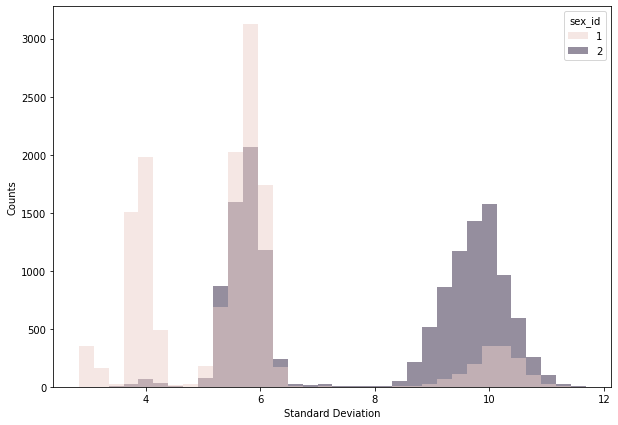

In [106]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data1, x='standard_deviation', hue='sex_id', stat='count', edgecolor=None)
ax.set(xlabel='Standard Deviation', ylabel='Counts')

Just doing a check that everything is looking as it should for both sexes

### Testing for an appropriate upper/lower/epsilon

In order to test for an appropriate error bound for the equation, I will make the function for a single row of data. This will allow it to run faster and so I can test epsilon values more easily. 

Since the standard deviations vary so greatly in the dataset, I am going to split the data into parts and have different spreads for each section. In the above histogram, it seems there are 3 main peaks in standard deviation values. I will reflect this with having the sets be: std>8, 8>std>5 and std<5.

In [18]:
def function3():
    return integrate.quad(lambda x: (bmi_ensemble(x, data1['mean'].iloc[0], 8)                                     
                                          *data1['RR_adj'].iloc[0]**((data1['TMREL'].iloc[0] - x + abs(data1['TMREL'].iloc[0] - x))/2)),
                          lower,upper,epsabs=0.0000001)

In [19]:
lower = 13
upper = 60
function3()

(1.0971673159602984, 7.328204976175812e-08)

After testing, I selected the bounds of upper=60, lower=13, and epsilon=0.00001

In [173]:
def function4():
    return integrate.quad(lambda x: (bmi_ensemble(x, data1['mean'].iloc[0], 5)                                     
                                          *data1['RR_adj'].iloc[0]**((data1['TMREL'].iloc[0] - x + abs(data1['TMREL'].iloc[0] - x))/2)),
                          lower,upper,epsabs=0.001)

In [169]:
lower = 17
upper = 45
function4()

(1.0126038868750735, 0.0003117275397416894)

For the middle group, I experimented with values. My goal is also to ensure the burden is greater than 1. After checking multiple options, I selected upper = 45, lower = 17, and epsilon = 0.001.

In [174]:
def function5():
    return integrate.quad(lambda x: (bmi_ensemble(x, data1['mean'].iloc[11212], 3)                                     
                                          *data1['RR_adj'].iloc[11212]**((data1['TMREL'].iloc[11212] - x + abs(data1['TMREL'].iloc[11212] - x))/2)),
                          lower,upper,epsabs=0.001)

In [172]:
lower = 19
upper = 37
function5()

(1.0164377682169, 0.00041886356969976155)

I hand selected a row I thought might be problematic and set the std to 3, which is just below the lowest std I have seen. So with the extreme case of row 11212. 

After testing, the best set to run but have a burden over 1 is upper = 37, lower = 19 and epsabs = 0.001. 

### Running the actual function for PAFs

I took the list of draws used from the current model V&V to make this faster. 

In [176]:
draws_list = ([ 29, 232, 357, 394, 602, 629, 650, 680, 829, 946])

When I actually ran the function with my selected outputs from above, it still would not converge for certain age/sex/draw combinations. This does make sense since I only tested on one age/sex/draw and there might be variation. I slowly increased the lower bound until I found a value that would run. 

In [177]:
%%time
data_final_hf = pd.DataFrame()
for draw in [i for i in list(draws_list)]:
    print(f'calculating draw number {draw}')
    burden = []
    burden1 = []
    burden2 = []
    df = data1.loc[(data1.draw==f'draw_{draw}') & (data1.standard_deviation > 8)]
    for i in list(range(0,len(df))):
        denom = integrate.quad(lambda x: (bmi_ensemble(x, df['mean'].iloc[i], df['standard_deviation'].iloc[i])                                     
                                          * df['RR_adj'].iloc[i]**((df['TMREL'].iloc[i] - x + abs(df['TMREL'].iloc[i] - x))/2)),
                                                      13, 60,
                              epsabs=0.00001)[0]
        burden.append(denom)
    df['burden'] = burden
    df['paf'] = (df['burden'] - 1) / df['burden']
    data_final_hf = data_final_hf.append(df)
    df1 = data1.loc[(data1.draw==f'draw_{draw}') & (data1.standard_deviation < 8) & (data1.standard_deviation > 5)]
    for i in list(range(0,len(df1))):
        denom1 = integrate.quad(lambda x: (bmi_ensemble(x, df1['mean'].iloc[i], df1['standard_deviation'].iloc[i])                                     
                                          * df1['RR_adj'].iloc[i]**((df1['TMREL'].iloc[i] - x + abs(df1['TMREL'].iloc[i] - x))/2)),
                                                      17, 45,
                              epsabs=0.001)[0]
        burden1.append(denom1)
    df1['burden'] = burden1
    df1['paf'] = (df1['burden'] - 1) / df1['burden']
    data_final_hf = data_final_hf.append(df1)
    df2 = data1.loc[(data1.draw==f'draw_{draw}') & (data1.standard_deviation < 5)]
    for i in list(range(0,len(df2))):
        denom2 = integrate.quad(lambda x: (bmi_ensemble(x, df2['mean'].iloc[i], df2['standard_deviation'].iloc[i])                                     
                                          * df2['RR_adj'].iloc[i]**((df2['TMREL'].iloc[i] - x + abs(df2['TMREL'].iloc[i] - x))/2)),
                                                      17, 37,
                              epsabs=0.001)[0]
        burden2.append(denom2)
    df2['burden'] = burden2
    df2['paf'] = (df2['burden'] - 1) / df2['burden']
    data_final_hf = data_final_hf.append(df2)
    print(f'Draw {draw} completed')

calculating draw number 29


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:28: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


NameError: name 'burden2' is not defined

In [24]:
data_final_hf.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,MF_SBP_1,RR_adj,TMREL,burden,paf
212,1,10,draw_29,28.200823,9.400274,1.136494,0.200490,1.109128,22.129338,1.081016,0.074944
7212,1,17,draw_29,29.393362,9.799361,1.134141,0.179977,1.109999,20.089635,1.015892,0.015643
14212,2,10,draw_29,28.630906,9.542931,1.153998,0.200490,1.123123,24.309632,1.203342,0.168981
15212,2,11,draw_29,29.263606,9.754838,1.140963,0.165174,1.117680,24.970110,1.209624,0.173297
16212,2,12,draw_29,29.461670,9.820557,1.142054,0.165101,1.118601,23.690466,1.134211,0.118330


In [25]:
data_final_hf.to_csv('/ihme/homes/lutzes/PAFs_BMI_HF_2.csv')

### BMI -> Ischemic Heart Disease

In [26]:
data_ihd = data[['sex_id','age_group_id','draw','mean','standard_deviation']]

In [27]:
ihd_rrs = get_draws(gbd_id_type='rei_id', 
                    gbd_id=370, 
                    source='rr', 
                    year_id=2019, 
                    gbd_round_id=6, 
                    status='best', 
                    decomp_step='step4')
ihd_rrs = ihd_rrs.loc[ihd_rrs.cause_id==493]

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


In [28]:
data2 = ihd_rrs.set_index(['sex_id','modelable_entity_id','age_group_id'])
data2 = (data2[[c for c in data2.columns if 'draw' in c]].stack().reset_index()
        .rename(columns={'level_3':'draw',0:'value'}))
data2['parameter'] = np.where(data2.modelable_entity_id==9031, 'mean', 'standard_deviation')
data2 = data2.drop(columns='modelable_entity_id')
data2 = (data2.pivot_table(index=['sex_id','age_group_id','draw'], columns='parameter', values='value')
        .reset_index())
data2 = data2.rename(columns = {'mean':'RR'})
data2.head()

parameter,sex_id,age_group_id,draw,RR
0,1,9,draw_0,3.510608
1,1,9,draw_1,1.740403
2,1,9,draw_10,1.525438
3,1,9,draw_100,2.891299
4,1,9,draw_101,2.206858


In [29]:
MF2 = pd.read_csv('/ihme/costeffectiveness/artifacts/vivarium_nih_us_cvd/raw_data/mediation_matrix_draw_gbd_2021_edited.csv')
IHD_MF = MF2.loc[(MF2.rei_id==370) & (MF2.cause_id==493)]
IHD_MF = IHD_MF.transpose()
IHD_MF.reset_index(inplace=True)
IHD_MF = IHD_MF.rename(columns = {75:'FPG',81:'SBP',88:'LDL','index':'draw'})
IHD_MF.head()

,draw,FPG,SBP,LDL
0,rei_id,370.000000,370.000000,370.000000
1,med_id,105.000000,107.000000,367.000000
2,cause_id,493.000000,493.000000,493.000000
3,mean_mediation,0.149278,0.311516,0.100209
4,draw_0,0.168698,0.288050,0.088317


In [30]:
data_ihd2 = data_ihd.merge(data2[['age_group_id','sex_id','draw','RR']], on=['age_group_id','sex_id','draw']).merge(IHD_MF[['draw','FPG','SBP','LDL']], on=['draw'])
data_ihd2['RR_adj'] = 1 + ((data_ihd2['RR'] - 1) * (1-data_ihd2['FPG']) * (1-data_ihd2['SBP']) * (1-data_ihd2['LDL']))
data_ihd2.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,FPG,SBP,LDL,RR_adj
0,1,10,draw_0,28.898947,9.591207,3.510608,0.168698,0.28805,0.088317,2.354663
1,1,11,draw_0,30.768116,10.256039,2.094858,0.168698,0.28805,0.088317,1.590759
2,1,12,draw_0,31.168189,10.389089,1.685112,0.168698,0.28805,0.088317,1.369670
3,1,13,draw_0,30.308706,10.100829,1.665879,0.168698,0.28805,0.088317,1.359292
4,1,14,draw_0,31.454214,10.475955,1.591258,0.168698,0.28805,0.088317,1.319028


In [31]:
np.random.seed(123)
test3 = np.random.uniform(20,25,28000)
data_ihd2['TMREL'] = test3
data_ihd2.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,FPG,SBP,LDL,RR_adj,TMREL
0,1,10,draw_0,28.898947,9.591207,3.510608,0.168698,0.28805,0.088317,2.354663,23.482346
1,1,11,draw_0,30.768116,10.256039,2.094858,0.168698,0.28805,0.088317,1.590759,21.430697
2,1,12,draw_0,31.168189,10.389089,1.685112,0.168698,0.28805,0.088317,1.369670,21.134257
3,1,13,draw_0,30.308706,10.100829,1.665879,0.168698,0.28805,0.088317,1.359292,22.756574
4,1,14,draw_0,31.454214,10.475955,1.591258,0.168698,0.28805,0.088317,1.319028,23.597345


In [32]:
%%time
data_final_ihd = pd.DataFrame()
for draw in [i for i in list(draws_list)]:
    print(f'calculating draw number {draw}')
    burden = []
    burden1 = []
    burden2 = []
    df = data_ihd2.loc[(data_ihd2.draw==f'draw_{draw}') & (data_ihd2.standard_deviation > 8)]
    for i in list(range(0,len(df))):
        denom = integrate.quad(lambda x: (bmi_ensemble(x, df['mean'].iloc[i], df['standard_deviation'].iloc[i])                                     
                                          * df['RR_adj'].iloc[i]**((df['TMREL'].iloc[i] - x + abs(df['TMREL'].iloc[i] - x))/2)),
                                                      13, 60,
                              epsabs=0.00001)[0]
        burden.append(denom)
    df['burden'] = burden
    df['paf'] = (df['burden'] - 1) / df['burden']
    data_final_ihd = data_final_ihd.append(df)
    df1 = data_ihd2.loc[(data_ihd2.draw==f'draw_{draw}') & (data_ihd2.standard_deviation < 8) & (data_ihd2.standard_deviation > 5)]
    for i in list(range(0,len(df1))):
        denom1 = integrate.quad(lambda x: (bmi_ensemble(x, df1['mean'].iloc[i], df1['standard_deviation'].iloc[i])                                     
                                          * df1['RR_adj'].iloc[i]**((df1['TMREL'].iloc[i] - x + abs(df1['TMREL'].iloc[i] - x))/2)),
                                                      17, 45,
                              epsabs=0.001)[0]
        burden1.append(denom1)
    df1['burden'] = burden1
    df1['paf'] = (df1['burden'] - 1) / df1['burden']
    data_final_ihd = data_final_ihd.append(df1)
    df2 = data_ihd2.loc[(data_ihd2.draw==f'draw_{draw}') & (data_ihd2.standard_deviation < 5)]
    for i in list(range(0,len(df2))):
        denom2 = integrate.quad(lambda x: (bmi_ensemble(x, df2['mean'].iloc[i], df2['standard_deviation'].iloc[i])                                     
                                          * df2['RR_adj'].iloc[i]**((df2['TMREL'].iloc[i] - x + abs(df2['TMREL'].iloc[i] - x))/2)),
                                                      17, 37,
                              epsabs=0.001)[0]
        burden2.append(denom2)
    df2['burden'] = burden2
    df2['paf'] = (df2['burden'] - 1) / df2['burden']
    data_final_ihd = data_final_ihd.append(df2)
    print(f'Draw {draw} completed')

calculating draw number 29


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 29 completed
calculating draw number 232


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 232 completed
calculating draw number 357


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 357 completed
calculating draw number 394


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 394 completed
calculating draw number 602


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 602 completed
calculating draw number 629


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 629 completed
calculating draw number 650


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 650 completed
calculating draw number 680


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 680 completed
calculating draw number 829


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 829 completed
calculating draw number 946


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 946 completed
CPU times: user 4h 35min 53s, sys: 21.4 s, total: 4h 36min 15s
Wall time: 4h 35min 53s


<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [33]:
data_final_ihd.to_csv('/ihme/homes/lutzes/PAFs_BMI_IHD.csv')

### BMI -> Ischemic Stroke

In [34]:
data_stroke = data[['sex_id','age_group_id','draw','mean','standard_deviation']]

In [35]:
stroke_rrs = get_draws(gbd_id_type='rei_id', 
                    gbd_id=370, 
                    source='rr', 
                    year_id=2019, 
                    gbd_round_id=6, 
                    status='best', 
                    decomp_step='step4')
stroke_rrs = stroke_rrs.loc[stroke_rrs.cause_id==495]

/ihme/homes/lutzes/.conda/envs/vivarium_nih_us_cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


In [36]:
data3 = stroke_rrs.set_index(['sex_id','modelable_entity_id','age_group_id'])
data3 = (data3[[c for c in data3.columns if 'draw' in c]].stack().reset_index()
        .rename(columns={'level_3':'draw',0:'value'}))
data3['parameter'] = np.where(data3.modelable_entity_id==9031, 'mean', 'standard_deviation')
data3 = data3.drop(columns='modelable_entity_id')
data3 = (data3.pivot_table(index=['sex_id','age_group_id','draw'], columns='parameter', values='value')
        .reset_index())
data3 = data3.rename(columns = {'mean':'RR'})
data3.head()

parameter,sex_id,age_group_id,draw,RR
0,1,9,draw_0,2.405075
1,1,9,draw_1,2.088226
2,1,9,draw_10,3.831654
3,1,9,draw_100,2.202777
4,1,9,draw_101,2.824795


In [37]:
stroke_MF = MF2.loc[(MF2.rei_id==370) & (MF2.cause_id==495)]
stroke_MF = stroke_MF.transpose()
stroke_MF.reset_index(inplace=True)
stroke_MF = stroke_MF.rename(columns = {76:'FPG',82:'SBP',89:'LDL','index':'draw'})
stroke_MF.head()

,draw,FPG,SBP,LDL
0,rei_id,370.000000,370.000000,370.000000
1,med_id,105.000000,107.000000,367.000000
2,cause_id,495.000000,495.000000,495.000000
3,mean_mediation,0.216638,0.646555,0.034331
4,draw_0,0.193331,0.645818,0.051478


In [38]:
data_stroke2 = data_stroke.merge(data3[['age_group_id','sex_id','draw','RR']], on=['age_group_id','sex_id','draw']).merge(stroke_MF[['draw','FPG','SBP','LDL']], on=['draw'])
data_stroke2['RR_adj'] = 1 + ((data_stroke2['RR'] - 1) * (1-data_stroke2['FPG']) * (1-data_stroke2['SBP']) * (1-data_stroke2['LDL']))
data_stroke2.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,FPG,SBP,LDL,RR_adj
0,1,10,draw_0,28.898947,9.591207,2.405075,0.193331,0.645818,0.051478,1.380775
1,1,11,draw_0,30.768116,10.256039,2.220086,0.193331,0.645818,0.051478,1.330643
2,1,12,draw_0,31.168189,10.389089,1.919950,0.193331,0.645818,0.051478,1.249306
3,1,13,draw_0,30.308706,10.100829,1.738278,0.193331,0.645818,0.051478,1.200073
4,1,14,draw_0,31.454214,10.475955,1.809969,0.193331,0.645818,0.051478,1.219501


In [39]:
np.random.seed(123)
test3 = np.random.uniform(20,25,28000)
data_stroke2['TMREL'] = test3
data_stroke2.head()

,sex_id,age_group_id,draw,mean,standard_deviation,RR,FPG,SBP,LDL,RR_adj,TMREL
0,1,10,draw_0,28.898947,9.591207,2.405075,0.193331,0.645818,0.051478,1.380775,23.482346
1,1,11,draw_0,30.768116,10.256039,2.220086,0.193331,0.645818,0.051478,1.330643,21.430697
2,1,12,draw_0,31.168189,10.389089,1.919950,0.193331,0.645818,0.051478,1.249306,21.134257
3,1,13,draw_0,30.308706,10.100829,1.738278,0.193331,0.645818,0.051478,1.200073,22.756574
4,1,14,draw_0,31.454214,10.475955,1.809969,0.193331,0.645818,0.051478,1.219501,23.597345


In [40]:
%%time
data_final_stroke = pd.DataFrame()
for draw in [i for i in list(draws_list)]:
    print(f'calculating draw number {draw}')
    burden = []
    burden1 = []
    burden2 = []
    df = data_stroke2.loc[(data_stroke2.draw==f'draw_{draw}') & (data_stroke2.standard_deviation > 8)]
    for i in list(range(0,len(df))):
        denom = integrate.quad(lambda x: (bmi_ensemble(x, df['mean'].iloc[i], df['standard_deviation'].iloc[i])                                     
                                          * df['RR_adj'].iloc[i]**((df['TMREL'].iloc[i] - x + abs(df['TMREL'].iloc[i] - x))/2)),
                                                      13, 60,
                              epsabs=0.00001)[0]
        burden.append(denom)
    df['burden'] = burden
    df['paf'] = (df['burden'] - 1) / df['burden']
    data_final_stroke = data_final_stroke.append(df)
    df1 = data_stroke2.loc[(data_stroke2.draw==f'draw_{draw}') & (data_stroke2.standard_deviation < 8) & (data_stroke2.standard_deviation > 5)]
    for i in list(range(0,len(df1))):
        denom1 = integrate.quad(lambda x: (bmi_ensemble(x, df1['mean'].iloc[i], df1['standard_deviation'].iloc[i])                                     
                                          * df1['RR_adj'].iloc[i]**((df1['TMREL'].iloc[i] - x + abs(df1['TMREL'].iloc[i] - x))/2)),
                                                      17, 45,
                              epsabs=0.001)[0]
        burden1.append(denom1)
    df1['burden'] = burden1
    df1['paf'] = (df1['burden'] - 1) / df1['burden']
    data_final_stroke = data_final_stroke.append(df1)
    df2 = data_stroke2.loc[(data_stroke2.draw==f'draw_{draw}') & (data_stroke2.standard_deviation < 5)]
    for i in list(range(0,len(df2))):
        denom2 = integrate.quad(lambda x: (bmi_ensemble(x, df2['mean'].iloc[i], df2['standard_deviation'].iloc[i])                                     
                                          * df2['RR_adj'].iloc[i]**((df2['TMREL'].iloc[i] - x + abs(df2['TMREL'].iloc[i] - x))/2)),
                                                      17, 37,
                              epsabs=0.001)[0]
        burden2.append(denom2)
    df2['burden'] = burden2
    df2['paf'] = (df2['burden'] - 1) / df2['burden']
    data_final_stroke = data_final_stroke.append(df2)
    print(f'Draw {draw} completed')

calculating draw number 29


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 29 completed
calculating draw number 232


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 232 completed
calculating draw number 357


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 357 completed
calculating draw number 394


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 394 completed
calculating draw number 602


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 602 completed
calculating draw number 629


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 629 completed
calculating draw number 650


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 650 completed
calculating draw number 680


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 680 completed
calculating draw number 829


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 829 completed
calculating draw number 946


<timed exec>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Draw 946 completed
CPU times: user 4h 17min 21s, sys: 21.7 s, total: 4h 17min 43s
Wall time: 4h 17min 20s


<timed exec>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [41]:
data_final_stroke.to_csv('/ihme/homes/lutzes/PAFs_BMI_stroke.csv')